In [1]:
import os
current_directory = os.getcwd()
print(current_directory)
dir_base = os.path.join(current_directory,'Dataset')
print(dir_base)

/home/ladans/DNN/Project/Extended model
/home/ladans/DNN/Project/Extended model/Dataset


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
import pandas as pd
import glob
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, Dropout, Flatten, 
    RepeatVector, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

In [22]:
# Directory containing CSV files
data_dir = dir_base  # Define the base directory

# Initialize an empty DataFrame
all_data = pd.DataFrame()

# Iterate over each file in the directory
for file_path in glob.glob(os.path.join(data_dir, "*.csv")):
    stock_symbol = os.path.basename(file_path).split('.')[0]
    df = pd.read_csv(file_path)
    df['Stock_Symbol'] = stock_symbol
    df = df[['Date', 'Open', 'Close', 'Stock_Symbol']]
    all_data = pd.concat([all_data, df], ignore_index=True)

# Sort by date and stock symbol
all_data = all_data.sort_values(['Stock_Symbol', 'Date']).reset_index(drop=True)

# Encode stock symbols
encoder = LabelEncoder()
all_data['Stock_Index'] = encoder.fit_transform(all_data['Stock_Symbol'])

# Normalize prices using MinMaxScaler across all stocks
scaler = MinMaxScaler(feature_range=(0, 1))
all_data['Normalized_Close'] = all_data.groupby('Stock_Symbol')['Close'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

all_data

,Date,Open,Close,Stock_Symbol,Stock_Index,Normalized_Close
0,2012-09-04,95.108574,96.424286,AAPL,0,0.375340
1,2012-09-05,96.510002,95.747147,AAPL,0,0.369085
2,2012-09-06,96.167145,96.610001,AAPL,0,0.377055
3,2012-09-07,96.864288,97.205711,AAPL,0,0.382558
4,2012-09-10,97.207146,94.677139,AAPL,0,0.359201
...,...,...,...,...,...,...
15792,2017-08-28,73.059998,72.830002,MSFT,12,0.959917
15793,2017-08-29,72.250000,73.050003,MSFT,12,0.964463
15794,2017-08-30,73.010002,74.010002,MSFT,12,0.984298
15795,2017-08-31,74.029999,74.769997,MSFT,12,1.000000


In [5]:
# Parameters
sequence_length = 32  # Adjusted based on optimization

X, y, stock_indices = [], [], []

for stock in all_data['Stock_Symbol'].unique():
    stock_data = all_data[all_data['Stock_Symbol'] == stock]
    normalized_prices = stock_data['Normalized_Close'].values

    # Create sequences of length `sequence_length`
    for i in range(len(normalized_prices) - sequence_length):
        X.append(normalized_prices[i: i + sequence_length])
        y.append(normalized_prices[i + sequence_length])
        stock_indices.append(stock_data['Stock_Index'].iloc[0])

X = np.array(X)
y = np.array(y)
stock_indices = np.array(stock_indices)

In [7]:
# Train-test split
train_ratio = 0.7
validation_ratio = 0.25
test_ratio = 0.05

# Calculate split sizes
train_size = int(len(X) * train_ratio)
validation_size = int(len(X) * validation_ratio)

# Perform the splits
X_train = X[:train_size]
y_train = y[:train_size]
stock_indices_train = stock_indices[:train_size]

X_val = X[train_size:train_size + validation_size]
y_val = y[train_size:train_size + validation_size]
stock_indices_val = stock_indices[train_size:train_size + validation_size]

X_test = X[train_size + validation_size:]
y_test = y[train_size + validation_size:]
stock_indices_test = stock_indices[train_size + validation_size:]

# Reshape inputs for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print sizes for verification
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 10766
Validation samples: 3845
Test samples: 770


In [26]:
# Number of unique stocks and embedding dimensions
num_stocks = len(all_data['Stock_Symbol'].unique())
embedding_size = 23  # Increased embedding size based on Optuna

# Define inputs
price_input = Input(shape=(sequence_length, 1), name="price_input")
stock_input = Input(shape=(1,), name="stock_input")

# Embedding layer for stock symbols
stock_embedding = Embedding(
    input_dim=num_stocks, 
    output_dim=16, 
    name="stock_embedding"
)(stock_input)
stock_embedding = Flatten()(stock_embedding)
stock_embedding = RepeatVector(sequence_length)(stock_embedding)

# Merge price input and embedding
merged_input = Concatenate(axis=2)([price_input, stock_embedding])

# LSTM layers
lstm_out = LSTM(128, return_sequences=True)(merged_input)
lstm_out = Dropout(0.1)(lstm_out)  # Apply Dropout correctly
lstm_out = LSTM(64, return_sequences=True)(lstm_out)

# Final LSTM layer
final_out = LSTM(32, return_sequences=False)(lstm_out)

# Output layer
output = Dense(1, activation="linear", name="output")(final_out)

# Define the model
model = Model(inputs=[price_input, stock_input], outputs=output)

# Compile the model with gradient clipping
optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
model.compile(optimizer=optimizer, loss="mean_squared_error")

# Train the model
history = model.fit(
    [X_train, stock_indices_train], y_train,
    validation_data=([X_val, stock_indices_val], y_val),
    epochs=50,
    batch_size=32,  # Adjust batch size for better performance
    verbose=1,
)

Epoch 1/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - loss: 0.0136 - val_loss: 0.0025
Epoch 2/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - loss: 0.0010 - val_loss: 8.0720e-04
Epoch 5/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - loss: 7.6769e-04 - val_loss: 6.9580e-04
Epoch 6/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - loss: 7.1838e-04 - val_loss: 6.8548e-04
Epoch 7/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - loss: 6.0042e-04 - val_loss: 5.8755e-04
Epoch 8/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: 5.7613e-04 - val_loss: 5.3436e-04
Epoch 9/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - loss: 5.2620e-04 - val_loss: 5.6626e-04
Epoch 10/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - loss: 5.3506e-04 - val_loss: 5.8193e-04
Epoch 11/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - loss: 4.87

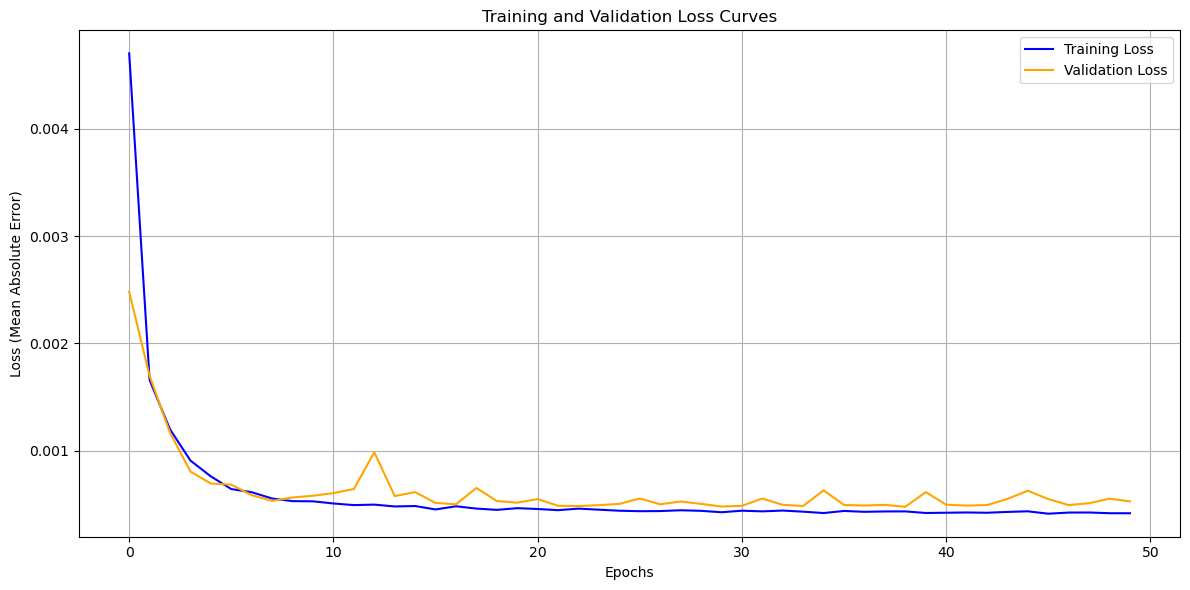

In [27]:
# Extract training and validation losses
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Absolute Error)')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('training_loss_optimized')
plt.show()


In [10]:
#Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming `model` is your trained model, `X_test` is your test data input
predicted_prices = model.predict([X_test, stock_indices_test])

# Denormalize predictions and actual values
def denormalize(values, stock_symbol):
    scaler = MinMaxScaler(feature_range=(0, 1))
    stock_prices = all_data[all_data['Stock_Symbol'] == stock_symbol]['Close'].values
    scaler.fit(stock_prices.reshape(-1, 1))
    return scaler.inverse_transform(values.reshape(-1, 1)).flatten()

y_test_denormalized = np.concatenate([
    denormalize(y_test[stock_indices_test == stock_id], encoder.inverse_transform([stock_id])[0])
    for stock_id in np.unique(stock_indices_test)
])

predicted_prices_denormalized = np.concatenate([
    denormalize(predicted_prices[stock_indices_test == stock_id], encoder.inverse_transform([stock_id])[0])
    for stock_id in np.unique(stock_indices_test)
])

# Calculate metrics
mae = mean_absolute_error(y_test_denormalized, predicted_prices_denormalized)
mse = mean_squared_error(y_test_denormalized, predicted_prices_denormalized)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_denormalized - predicted_prices_denormalized) / y_test_denormalized)) * 100

print("MAE (Original Scale):", mae)
print("MSE (Original Scale):", mse)
print("RMSE (Original Scale):", rmse)
print("MAPE:", mape, "%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
MAE (Original Scale): 0.5102605404826377
MSE (Original Scale): 0.5347696718062004
RMSE (Original Scale): 0.731279475854615
MAPE: 0.9749073336706477 %


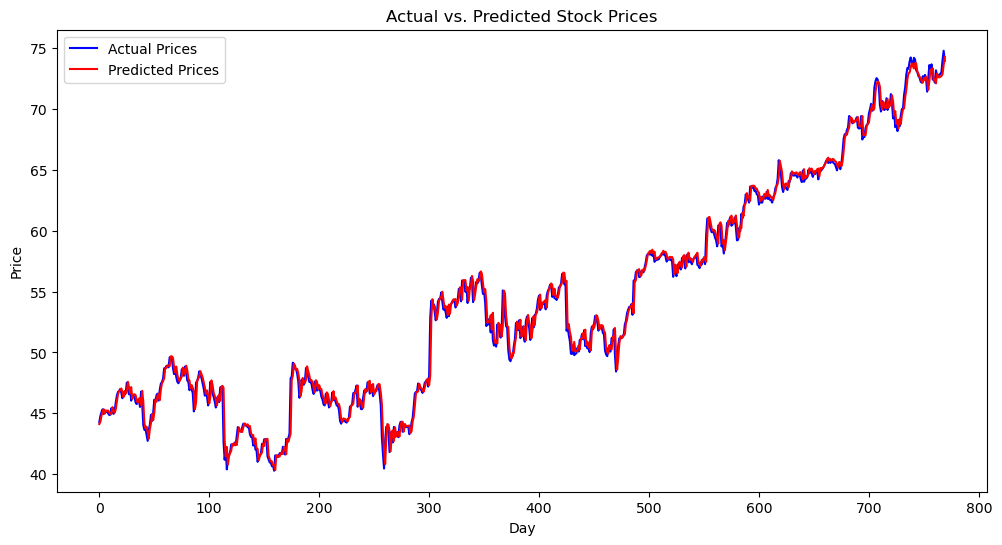

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_denormalized, label="Actual Prices", color="blue")
plt.plot(predicted_prices_denormalized, label="Predicted Prices", color="red")
plt.xlabel("Day")
plt.ylabel("Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.savefig('actual_prediction_optimized')
plt.show()

# Evaluate per-stock metrics
for stock_id in np.unique(stock_indices_test):
    stock_mask = stock_indices_test == stock_id
    stock_symbol = encoder.inverse_transform([stock_id])[0]
    stock_mae_reversed = mean_absolute_error(
        y_test_denormalized[stock_mask], predicted_prices_denormalized[stock_mask]
    )

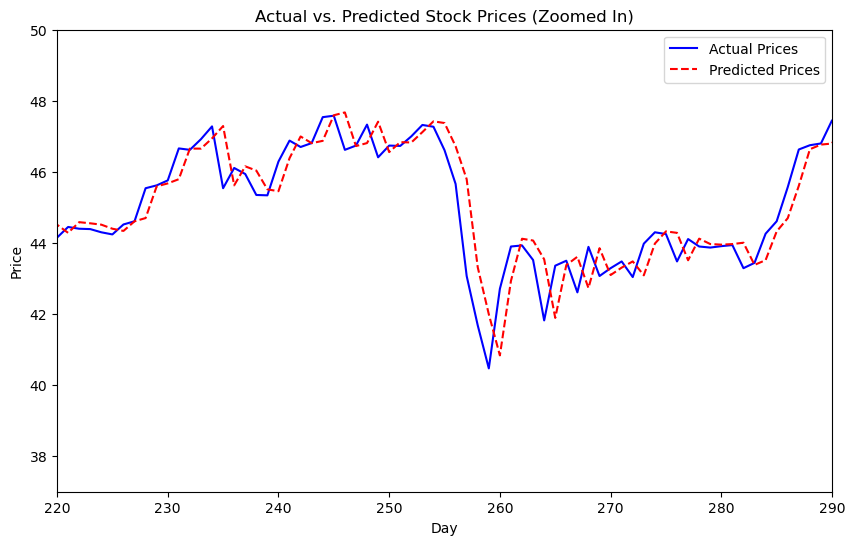

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_denormalized, label="Actual Prices", color="blue")
plt.plot(predicted_prices_denormalized, label="Predicted Prices", color="red", linestyle='--')

plt.xlim(220, 290)  # Zoom into x-axis (e.g., focus on indices 100 to 200)
plt.ylim(37, 50)    # Zoom into y-axis (e.g., focus on prices between 40 and 60)

plt.title("Actual vs. Predicted Stock Prices (Zoomed In)")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.savefig('zoomed')
plt.show()


In [13]:
# Predict the next price for a new sequence
array_34_values = X_test[-1]  

# Reshape new_sequence to match the model's expected input shape
new_sequence = array_34_values.reshape((1, sequence_length, 1))

# Find the encoded index for the desired stock (e.g., MSFT)
stock_index = encoder.transform(['MSFT'])

# Predict the normalized price
predicted_normalized_price = model.predict([new_sequence, stock_index])

# Reverse normalization to get the predicted price in the original scale
predicted_price_original_scale = scaler.inverse_transform(predicted_normalized_price)[0][0]

print("Predicted next price for MSFT (original scale):", predicted_price_original_scale)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted next price for MSFT (original scale): 74.2621


In [14]:
df_new=[]
# Directory containing CSV files
data_dir = dir_base  # Define this as your base directory

# Initialize an empty DataFrame
all_data_new = pd.DataFrame()

# Iterate over each file in the directory
for file_path in glob.glob(os.path.join(data_dir, "*.csv")):
    stock_symbol = os.path.basename(file_path).split('.')[0]
    df_new = pd.read_csv(file_path)
    df_new['Stock_Symbol'] = stock_symbol
    df_new = df_new[['Date', 'Open', 'Close', 'Stock_Symbol']]
    all_data_new = pd.concat([all_data_new, df_new], ignore_index=True)

# Sort by date and stock symbol
all_data_new = all_data_new.sort_values(['Stock_Symbol', 'Date']).reset_index(drop=True)

# Encode stock symbols
encoder = LabelEncoder()
all_data_new['Stock_Index'] = encoder.fit_transform(all_data_new['Stock_Symbol'])

In [15]:
all_data_new

,Date,Open,Close,Stock_Symbol,Stock_Index
0,2012-09-04,95.108574,96.424286,AAPL,0
1,2012-09-05,96.510002,95.747147,AAPL,0
2,2012-09-06,96.167145,96.610001,AAPL,0
3,2012-09-07,96.864288,97.205711,AAPL,0
4,2012-09-10,97.207146,94.677139,AAPL,0
...,...,...,...,...,...
15792,2017-08-28,73.059998,72.830002,MSFT,12
15793,2017-08-29,72.250000,73.050003,MSFT,12
15794,2017-08-30,73.010002,74.010002,MSFT,12
15795,2017-08-31,74.029999,74.769997,MSFT,12


In [16]:
y_test_denormalized_df = pd.DataFrame(y_test_denormalized)
predicted_prices_denormalized_df = pd.DataFrame(predicted_prices_denormalized)
print(len(y_test_denormalized_df))
print(len(predicted_prices_denormalized_df))

770
770


In [17]:
# Convert DataFrames to Series to make them 1D
y_test_denormalized_df_series = y_test_denormalized_df.iloc[:, 0]
predicted_prices_denormalized_series = predicted_prices_denormalized_df.iloc[:, 0]
open_series = all_data_new['Open'].iloc[-735:].reset_index(drop=True)

# Combine into a new DataFrame
sig = pd.DataFrame({
    'Open': open_series, 
    'Close': y_test_denormalized_df_series, 
    'Reversed_Predicted_Prices': predicted_prices_denormalized_series
})

print(sig)

          Open      Close  Reversed_Predicted_Prices
0    45.980000  44.270000                  44.122452
1    46.119999  44.790001                  44.314091
2    45.860001  45.110001                  44.805035
3    45.480000  45.330002                  45.118374
4    46.500000  44.950001                  45.342007
..         ...        ...                        ...
765        NaN  72.830002                  72.627914
766        NaN  73.050003                  72.694221
767        NaN  74.010002                  72.855812
768        NaN  74.769997                  73.604790
769        NaN  73.940002                  74.262100

[770 rows x 3 columns]


In [18]:
counter=0
for i in range(len(sig)):
    a=sig['Close'].iloc[i]-sig['Open'].iloc[i]
    b=sig['Reversed_Predicted_Prices'].iloc[i]-sig['Open'].iloc[i]
    c=a*b
    if c>=0:
        counter =counter+1

counter

712

In [19]:
print(counter/len(sig))

0.9246753246753247
